# SIRD Model

## Equations
* From https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIRD_model , without considering natural birth and death rate.

\begin{equation}
\begin{split}
\dot{S} &= -\frac{\beta I S}{N}\\
\dot{I} &= \frac{\beta I S}{N} - \gamma I - \mu I\\
\dot{R} & = \gamma I\\
\dot{D} & = \mu I
\end{split}
\end{equation}

## Variables
* $S$: Susceptible individuals
* $I$: Infected individuals
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $N=S+I+R+D$ Total population size (constant)

## Parameters
* $\beta$ rate at which infected individuals contact susceptibles and infect them
* $\gamma$ rate at which infected individuals recover from disease and become immune
* $\mu$ death rate for infected individuals

## Basic reproductive ratio
* From https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7438206/
\begin{equation}
R_0 = \frac{\beta}{\gamma + \mu}
\end{equation}

# SIRD Simulation

## Libaries

In [100]:
import numpy as np, matplotlib.pyplot as plt
from scipy.integrate import odeint

## SIRD Model

In [101]:
#Defining the differential equations
#Don't track S because all variables must add up to N

def SIRD(y, t, b, g, u, N): 
    dy=[0, 0, 0] # I, R, D
    S = N - sum(y);
    dy[0] = b*S*y[0]/N-(g+u)*y[0] # dI
    dy[1] = g*y[0] # dR
    dy[2] = u*y[0] # dD

    return dy

## Simulation with Given Parameters

In [142]:
# Define parameters and run ODE
# test for Kaohsiung
N = 3975803
b = 1.2  #beta
g = 0.9 # gamma
u = 0.0002 # mu

#Calculate basic reproductive ratio
R0 = b / (g + u)
print("R0 = {0:4.2f}".format(R0))

R0 = 1.33


## Plot
Plot on linear and log scale

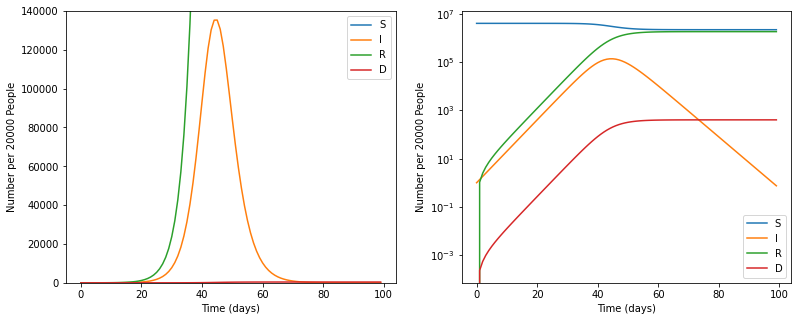

In [143]:
tmax = 100 # time length
tvec = np.arange(0, tmax, 1)
ic = np.zeros(3)
ic[0] = 1

soln = odeint(SIRD, ic, tvec, args=(b, g, u, N))
soln = np.hstack((N - np.sum(soln, axis=1, keepdims=True), soln))

plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.plot(tvec, soln)
plt.xlabel("Time (days)")
plt.ylabel("Number per 20000 People")
plt.legend(("S", "I", "R", "D"))
plt.ylim([0, 140000])

#Same plot but on log scale
plt.subplot(1, 2, 2)
plt.plot(tvec, soln)
plt.semilogy()
plt.xlabel("Time (days)")
plt.ylabel("Number per 20000 People")
plt.legend(("S", "I", "R", "D"))
# plt.ylim([1, 200000])
#plt.tight_layout()

## Growth Rate

In [ ]:
# get observed growth rate r (and doubling time) for a particular variable between selected time points
#(all infected classes eventually grow at same rate during early infection)

#Don't have a simple analytic formula for r for this model due to the complexity of the stages

def growth_rate(tvec, soln, t1, t2, i):
  i1 = np.where(tvec == t1)[0][0]
  i2 = np.where(tvec == t2)[0][0]
  r = (np.log(soln[i2, 1]) - np.log(soln[i1, 1])) / (t2 - t1)
  DoublingTime=np.log(2) / r

  return r, DoublingTime

In [ ]:
(r, DoublingTime)=growth_rate(tvec, soln, 10, 20, 1)
print("The epidemic growth rate is = {0:4.2f} per day and the doubling time {1:4.1f} days ".format(r, DoublingTime))

The epidemic growth rate is = 0.11 per day and the doubling time  6.4 days 


# Estimate SIRD Model with Grid Search (Start from Here!!!)
* Reference: https://github.com/Lewuathe/COVID19-SIR/blob/master/solver.py


---


* I、R、D 表示每日狀態為確診、康復、死亡的人數
* 先以每日新增確診數推估每日的 I、R ，也以每日 COVID-19 死亡數算出 D
* 以推估出的 I、R、D 找出誤差最小的 SIRD 曲線，也就是找出決定曲線形狀的最佳 b, g, u
    * 使用 grid search
* 使用此 SIRD 曲線預測接下來三天的新增確診數
    * 需要由預測出未來的 I、R、D 數值推算



## Libaries

In [424]:
import numpy as np, matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd
from datetime import datetime

## Some Parameters

In [425]:
# data selection
start_date = "2022-03-10"
end_date   = "2022-06-01"

delta_date = datetime.strptime(end_date, "%Y-%m-%d") - datetime.strptime(start_date, "%Y-%m-%d")
data_size = delta_date.days + 1
print(data_size)
test_size = 3
train_size = data_size - test_size
test_start_date = (pd.to_datetime(end_date) + pd.DateOffset(days=(-test_size+1))).strftime("%Y-%m-%d")

city_code = ["KEE", "NWT", "TPE", "TAO", "HSZ", "HSQ", "MIA", "TXG", "CHA", "NAN", "YUN", "CYQ", "CYI", "TNN", "KHH", "PIF", "ILA", "HUA", "TTT", "PEN", "KIN", "LIE"]
# city_code = ["NWT", "TPE", "TXG", "KHH", "TTT", "PEN", "TW"]

# model parameters
b_range = np.arange(0.55, 0.9, 0.01)
g_range = np.arange(0.4, 0.8, 0.01)
u_range = [0.0002]      # fixed death rate

84


## SIRD Model

In [426]:
#Defining the differential equations
#Don't track S because all variables must add up to N

def SIRD(y, t, b, g, u, N): 
    dy=[0, 0, 0] # I, R, D
    S = N - sum(y);
    dy[0] = b*S*y[0]/N-(g+u)*y[0] # dI
    dy[1] = g*y[0] # dR
    dy[2] = u*y[0] # dD

    return dy

## Mean Square Error for I, R, and D

In [427]:
def MSE(timelineI, timelineR, timelineD, N, b, g, u):
    tmax = len(timelineI)
    tvec = np.arange(0, tmax, 1)
    ird = np.zeros(3)
    ird[0] = 1

    soln = odeint(SIRD, ird, tvec, args=(b, g, u, N)).transpose()

    lossI = np.mean(np.power(soln[0] - timelineI, 2))
    lossR = np.mean(np.power(soln[1] - timelineR, 2))
    lossD = np.mean(np.power(soln[2] - timelineD, 2))
    return lossI + lossD + lossR/100

## Search Parameters with Minimal MSE

In [428]:
def gridSearch(N, timelineI, timelineR, timelineD):
    minError = np.infty
    best_b, best_g, best_u = -1, -1, -1

    for b in b_range:
        for g in g_range:
            for u in u_range:  
                error = MSE(timelineI, timelineR, timelineD, N, b, g, u)
                if error < minError:
                    best_b, best_g, best_u = b, g, u
                    minError = error

    return best_b, best_g, best_u


## Plot

Plot appromate/estimated I, R, and D on linear and log scale.

In [429]:
def plotEsti(timelineI, timelineR, timelineD, N, b, g, u, city):
    tvec = np.arange(0, len(timelineI), 1)
    soln = odeint(SIRD, np.array([1, 0, 0]), tvec, args=(b, g, u, N))

    solI = np.vstack((soln[:, 0], timelineI)).transpose()
    solR = np.vstack((soln[:, 1], timelineR)).transpose()
    solD = np.vstack((soln[:, 2], timelineD)).transpose()

    # I
    plt.figure(figsize=(10, 12))

    plt.subplot(3, 2, 1)
    plt.plot(tvec, solI)
    plt.xlabel("Time (days)")
    plt.ylabel("I")
    plt.legend(("pred", "real"))
    plt.axvline(x=(train_size-1), c='red', linestyle=':')
    # plt.ylim([0,20000])

    # I but on log scale
    plt.subplot(3, 2, 2)
    plt.plot(tvec, solI)
    plt.semilogy()
    plt.xlabel("Time (days)")
    plt.ylabel("I")
    plt.legend(("estimation", "reality"))
    plt.axvline(x=(train_size-1), c='red', linestyle=':')
    # plt.ylim([1,20000])

    plt.subplot(3, 2, 3)
    plt.plot(tvec, solR)
    plt.xlabel("Time (days)")
    plt.ylabel("R")
    plt.legend(("pred", "real"))
    plt.axvline(x=(train_size-1), c='red', linestyle=':')
    # plt.ylim([0,20000])

    plt.subplot(3, 2, 4)
    plt.plot(tvec, solR)
    plt.semilogy()
    plt.xlabel("Time (days)")
    plt.ylabel("R")
    plt.legend(("estimation", "reality"))
    plt.axvline(x=(train_size-1), c='red', linestyle=':')
    # plt.ylim([1,20000])

    plt.subplot(3, 2, 5)
    plt.plot(tvec, solD)
    plt.xlabel("Time (days)")
    plt.ylabel("D")
    plt.legend(("pred", "real"))
    plt.axvline(x=(train_size-1), c='red', linestyle=':')
    # plt.ylim([0,20000])
    
    plt.subplot(3, 2, 6)
    plt.plot(tvec, solD)
    plt.semilogy()
    plt.xlabel("Time (days)")
    plt.ylabel("D")
    plt.legend(("pred", "real"))
    plt.axvline(x=(train_size-1), c='red', linestyle=':')
    # plt.ylim([0,20000])

    plt.suptitle(f'Time-Series Prediction in {city}', y=0.9)

    plt.show()

Test error

In [430]:
def printPredDiff(pred, timeline_y):
    pred_sum = np.sum(pred)
    real_sum = np.sum(timeline_y)

    print(f"Diff: {(pred_sum - real_sum) * 100 / real_sum:.2f}%")

Plot estimated and real new cases on linear and log scale.

In [431]:
def estiNew(soln):
    esti_new_infected = [soln[0][0]]
    for i in range(1, data_size):
        delta_I = soln[i][0] - soln[i-1][0]
        delta_R = soln[i][1] - soln[i-1][1]
        delta_D = soln[i][2] - soln[i-1][2]

        esti_new_infected.append(delta_I + delta_R + delta_D)

    esti_new_infected = np.array(esti_new_infected).transpose()
    return esti_new_infected

In [432]:
def plotNewCases(new_infected_data, N, b, g, u, city):
    tvec = np.arange(0, data_size, 1)
    soln = odeint(SIRD, np.array([1, 0, 0]), tvec, args=(b, g, u, N))
    soln = estiNew(soln)
    soln = np.rint(soln)
    _soln = np.vstack((soln, new_infected_data)).transpose()

    plt.figure(figsize=(13, 5))
    plt.subplot(1, 2, 1)
    plt.plot(tvec, _soln)
    plt.xlabel("Time (days)")
    plt.ylabel("Number of New Cases")
    plt.legend(("estimation", "reality"))
    plt.axvline(x=(train_size-1), c='red', linestyle=':')
    # plt.ylim([0,20000])

    #Same plot but on log scale
    plt.subplot(1, 2, 2)
    plt.plot(tvec, _soln)
    plt.semilogy()
    plt.xlabel("Time (days)")
    plt.ylabel("Number of New Cases")
    plt.legend(("estimation", "reality"))
    plt.axvline(x=(train_size-1), c='red', linestyle=':')
    # plt.ylim([1,20000])
    # plt.tight_layout()

    plt.suptitle(f'Time-Series Prediction in {city}')

    plt.show()
    printPredDiff(soln[-test_size:], new_infected_data[-test_size:])

## Estimate for Cities

Get the approximate numbers of infected, recovered, and dead individuals respectively.


In [433]:
def getIRD(new_infected_data, new_dead_data):
    timelineI = []
    timelineR = []
    timelineD = []
    
    infected = 0
    dead = 0
    recovered = 0

    for i in range(len(new_infected_data)):
        infected += (new_infected_data[i] - new_dead_data[i])
        dead += new_dead_data[i]

        new_recover = 0
        # Better R?
        new_recover += int(new_infected_data[i-6] * 0.2)  if (i-6 >= 0) else 0
        new_recover += int(new_infected_data[i-5] * 0.3)   if (i-5 >= 0) else 0
        new_recover += int(new_infected_data[i-4] * 0.3)   if (i-4 >= 0) else 0
        new_recover += int(new_infected_data[i-3] * 0.196) if (i-3 >= 0) else 0

        infected -= new_recover
        recovered += new_recover

        timelineI.append(infected)
        timelineR.append(recovered)
        timelineD.append(dead)

    return timelineI, timelineR, timelineD


Get data for target city.

In [434]:
def getCityData(populationDf, confirmedDf, deadDf, city):
    # population: int
    # timeline: np.array([...])

    population = int(populationDf[populationDf['Region'] == city]['population'])

    confirmedCityDf = confirmedDf.loc[confirmedDf['city'] == city].asfreq('D')
    confirmedCityDf = confirmedCityDf[((confirmedCityDf.index >= start_date)
                                        & (confirmedCityDf.index <= end_date))]
    new_infected_data = confirmedCityDf.loc[:, 'count'].fillna(0).values

    deadCityDf = deadDf.loc[deadDf['city'] == city].asfreq('D')
    deadCityDf = deadCityDf[((deadCityDf.index >= start_date)
                            & (deadCityDf.index <= end_date))]
    new_dead_data = deadCityDf.loc[:, 'death_new'].fillna(0).values

    timelineI, timelineR, timelineD = getIRD(new_infected_data, new_dead_data)

    return population, new_infected_data, timelineI, timelineR, timelineD

Estimate parameters for one city or Taiwan.

In [435]:
def estiCity(N, timelineI, timelineR, timelineD, city):
    # Kaohsiung data
    # new_infected_data = np.array([1,3,1,1,2,1,11,4,1,3,2,3,2,4,6,6,1,5,34,36,50,30,25,30,49,63,45,50,59,41,26,50,106,68,121,96,135,152,198,269,352,393,468,441,679,818,1042,1183,1782,2180,2076,1981,2069,3740,3326,3754,3886,3990,4341,5086,6967,6818,7788,7858,7451,7450,9774,9985,8809,11636,10023,9915,8616,10832,11728,10529])
    # N = 2700000    # city population
    b, g, u = gridSearch(N, train_timelineI, train_timelineR, train_timelineD)

    print(f"Best parameters: b = {b}, g = {g}, u = {u}")
    print(f"Train minimal MSE = {MSE(train_timelineI, train_timelineR, train_timelineD, N, b, g, u)}")
    return b, g, u

Estimate for all cities.

===== City: KEE =====
population = 361612
Best parameters: b = 0.6300000000000001, g = 0.4900000000000001, u = 0.0002
Train minimal MSE = 3404130.1888271114


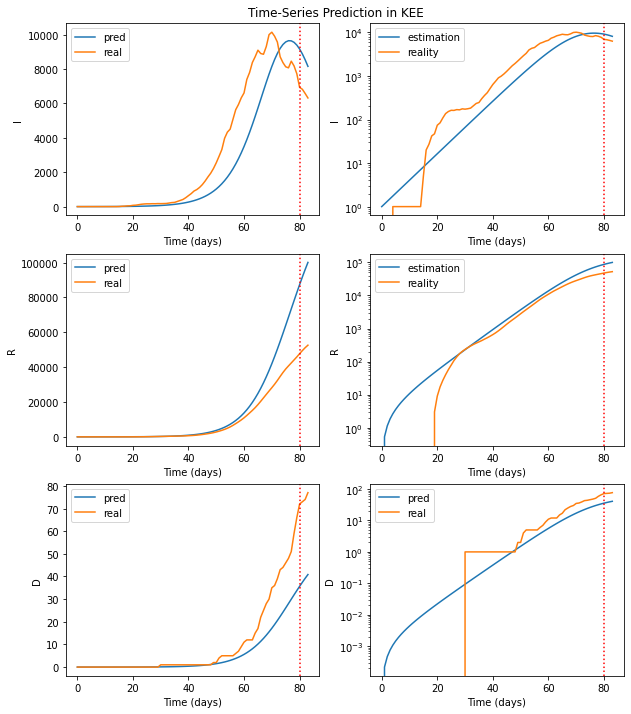

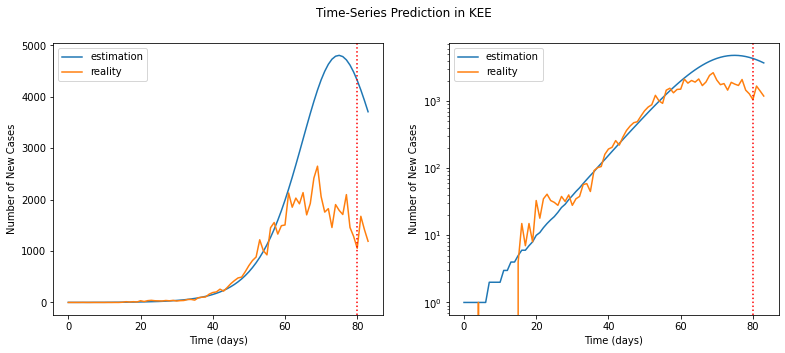

Diff: 174.89%
===== City: NWT =====
population = 3975803
Best parameters: b = 0.8000000000000003, g = 0.6200000000000002, u = 0.0002
Train minimal MSE = 616894857.3224887


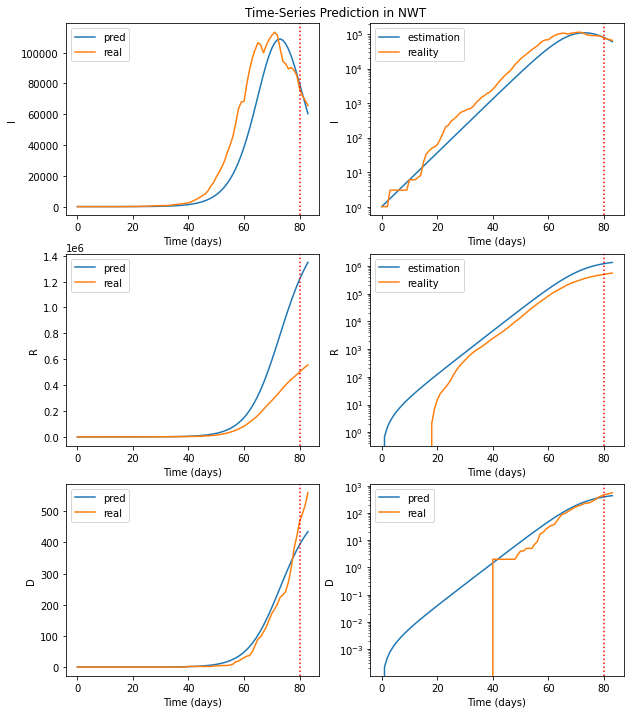

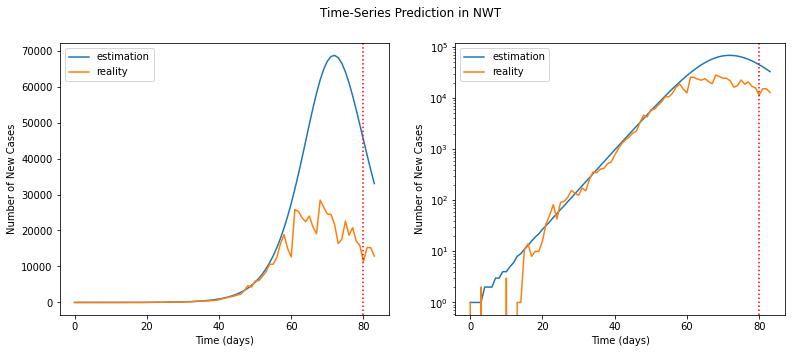

Diff: 155.63%
===== City: TPE =====
population = 2478124
Best parameters: b = 0.8700000000000003, g = 0.7100000000000003, u = 0.0002
Train minimal MSE = 147438449.40261078


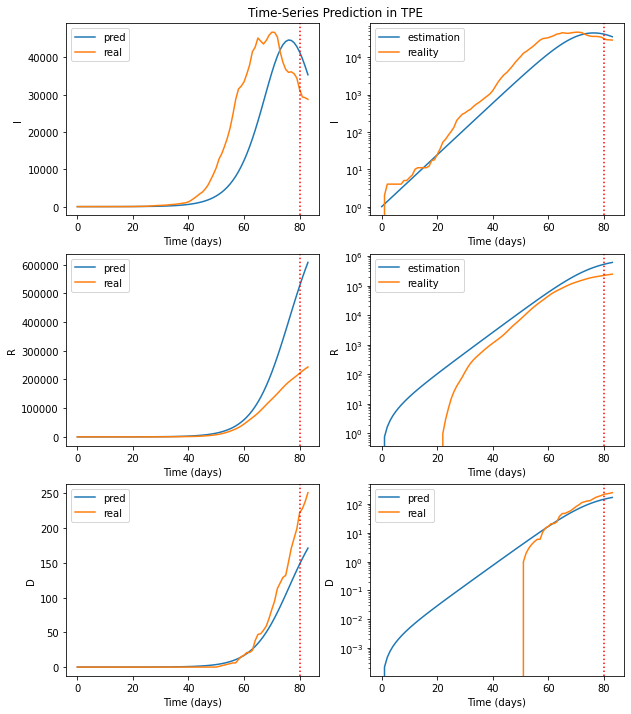

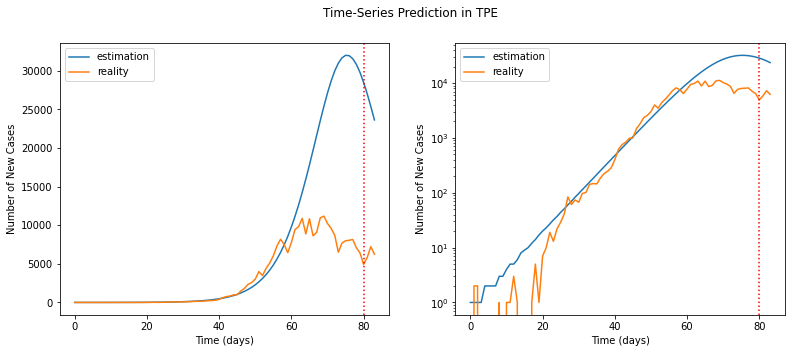

Diff: 294.09%
===== City: TAO =====
population = 2263430
Best parameters: b = 0.7500000000000002, g = 0.5900000000000002, u = 0.0002
Train minimal MSE = 108965583.19533727


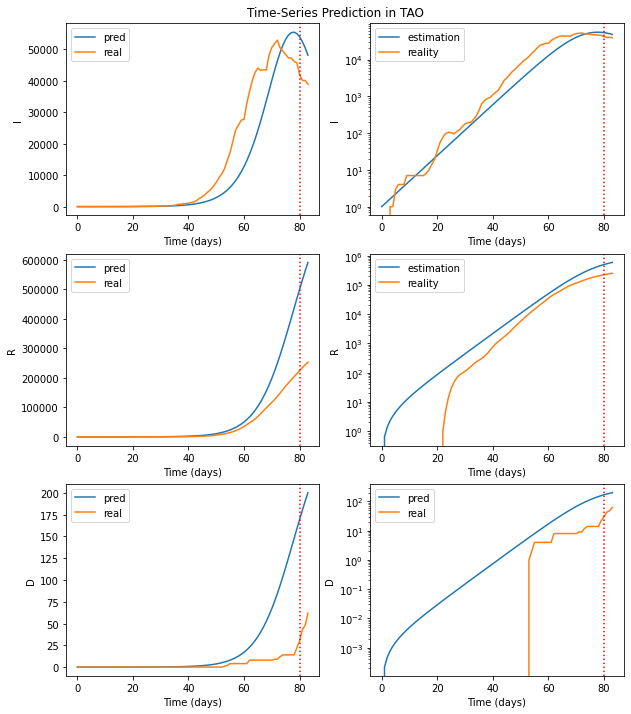

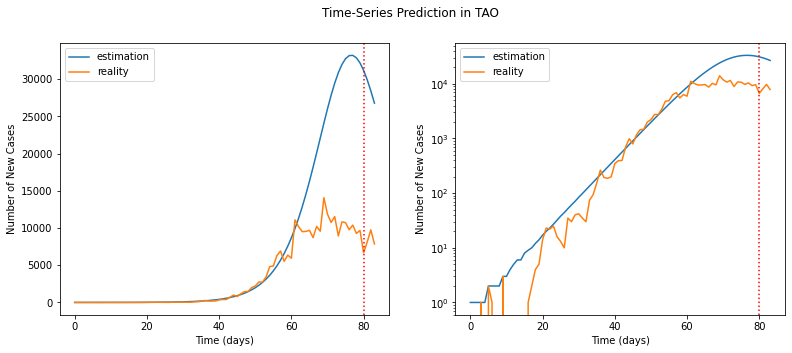

Diff: 230.71%
===== City: HSZ =====
population = 450494
Best parameters: b = 0.55, g = 0.43000000000000005, u = 0.0002
Train minimal MSE = 1300814.2096734897


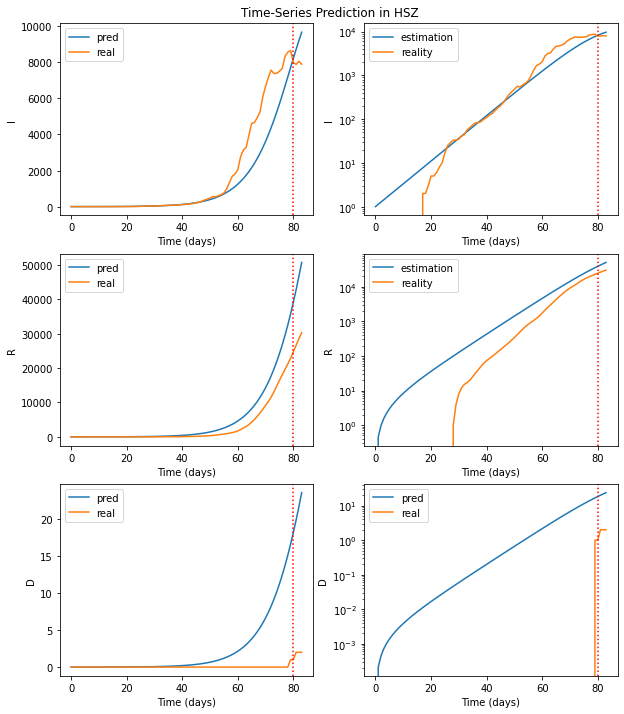

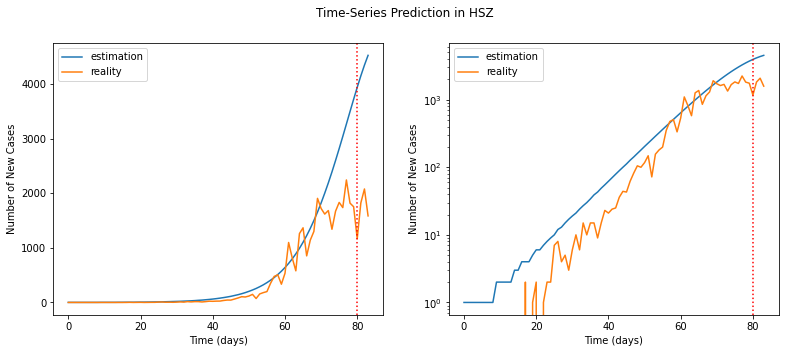

Diff: 137.35%
===== City: HSQ =====
population = 575682
Best parameters: b = 0.55, g = 0.42000000000000004, u = 0.0002
Train minimal MSE = 2673453.957614352


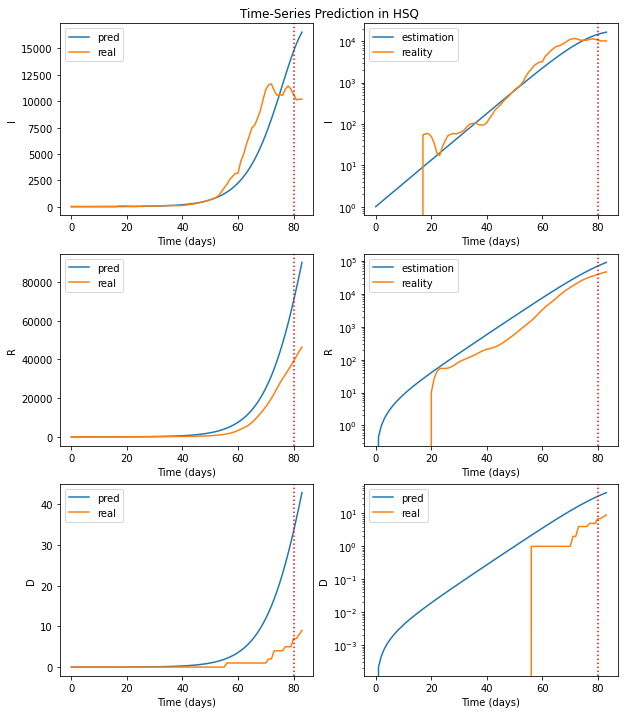

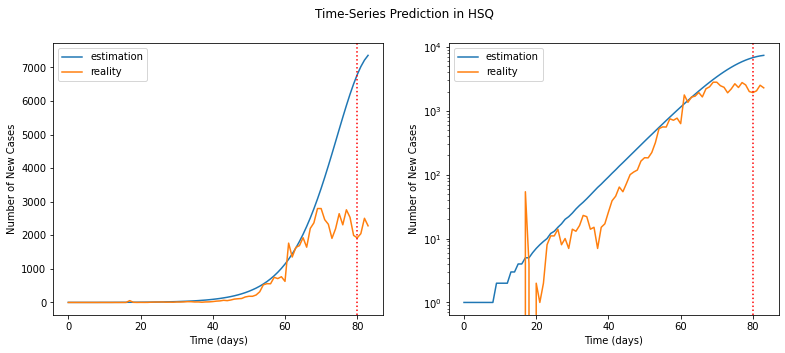

Diff: 215.86%
===== City: MIA =====
population = 535780
Best parameters: b = 0.55, g = 0.43000000000000005, u = 0.0002
Train minimal MSE = 640793.6559861754


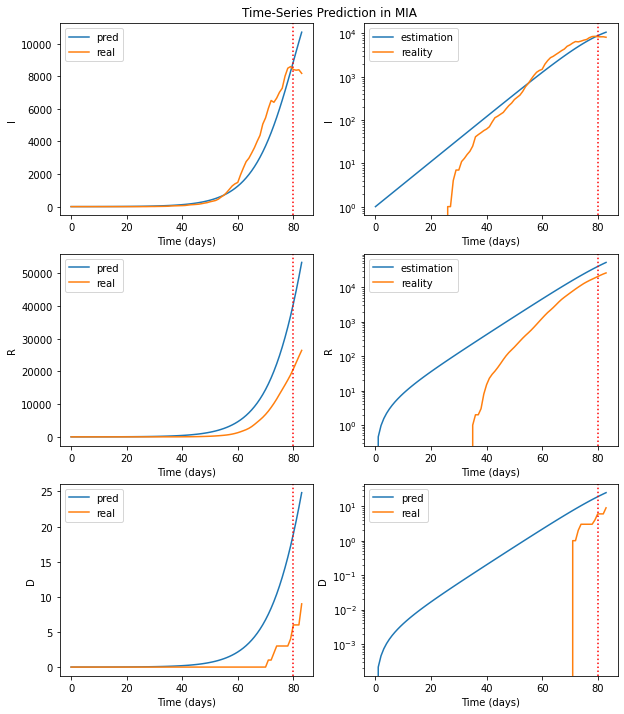

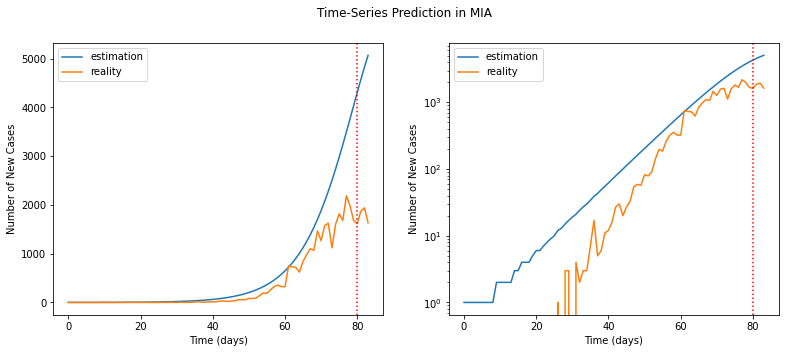

Diff: 165.55%
===== City: TXG =====
population = 2801069
Best parameters: b = 0.55, g = 0.41000000000000003, u = 0.0002
Train minimal MSE = 23945816.10982275


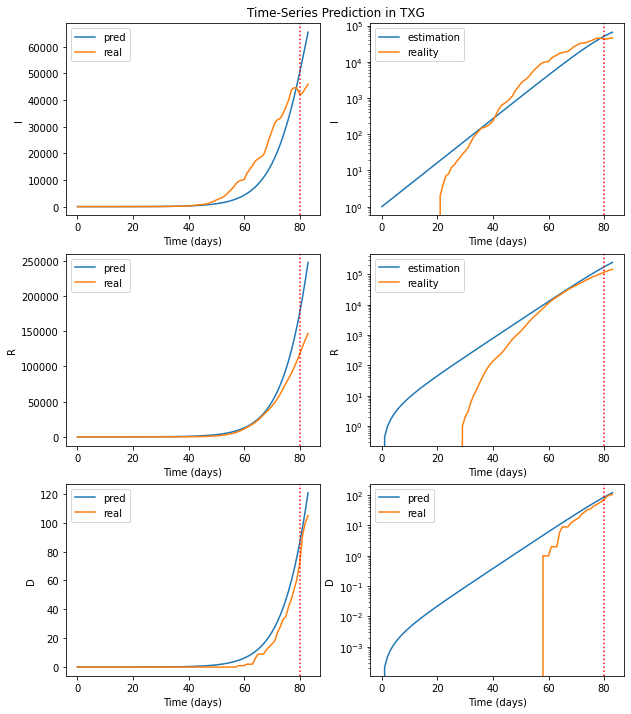

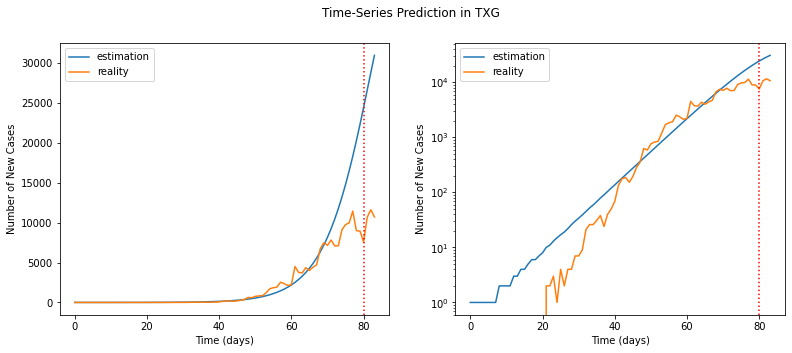

Diff: 161.68%
===== City: CHA =====
population = 1248262
Best parameters: b = 0.55, g = 0.42000000000000004, u = 0.0002
Train minimal MSE = 2210563.3220939133


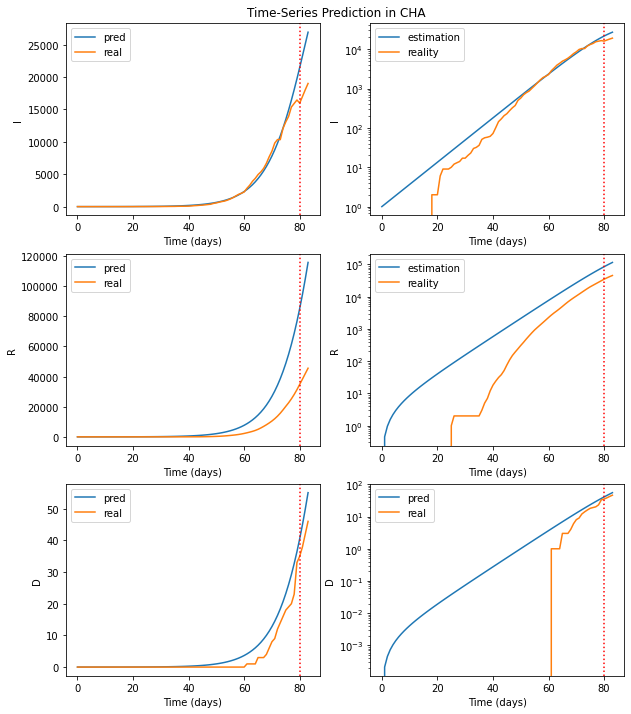

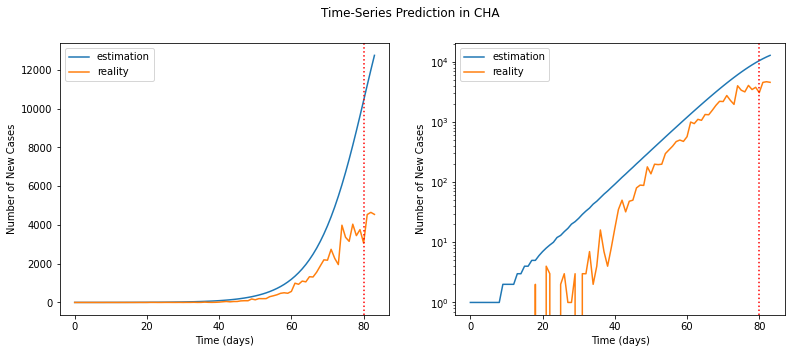

Diff: 161.85%
===== City: NAN =====
population = 481943
Best parameters: b = 0.55, g = 0.44000000000000006, u = 0.0002
Train minimal MSE = 361668.81993889814


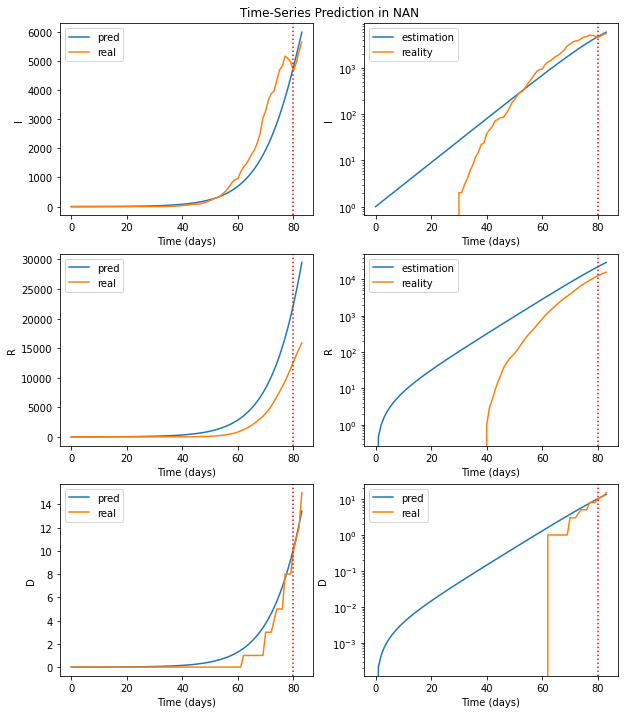

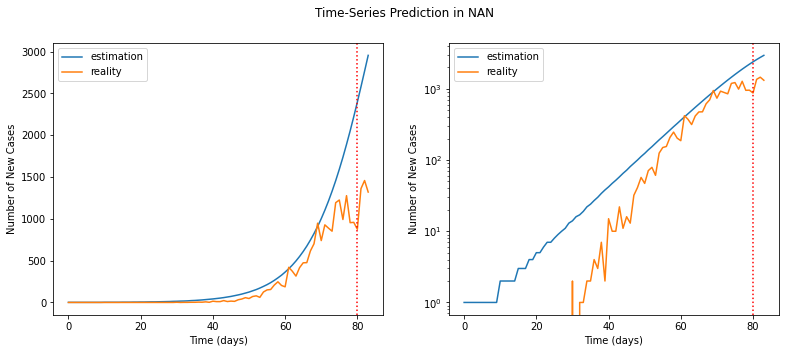

Diff: 100.53%
===== City: YUN =====
population = 666655
Best parameters: b = 0.55, g = 0.44000000000000006, u = 0.0002
Train minimal MSE = 667595.3235069779


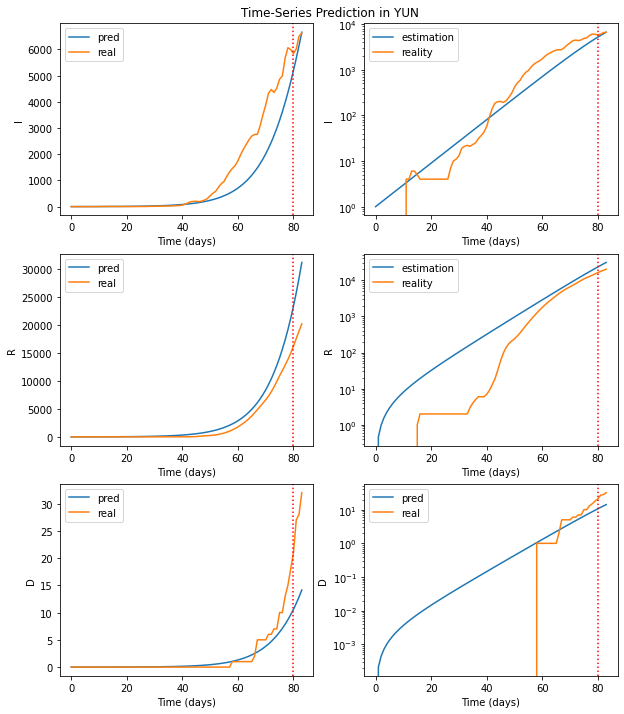

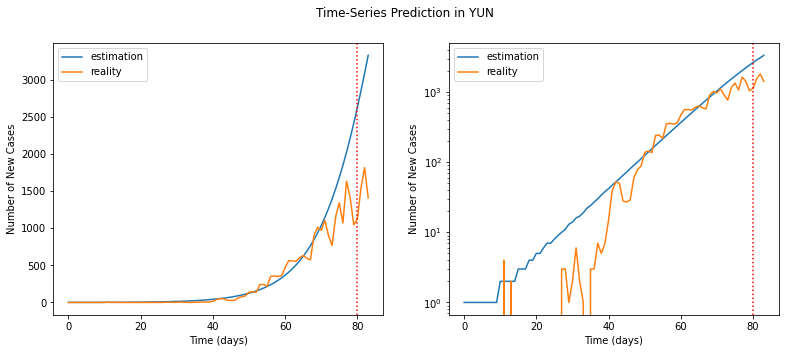

Diff: 94.35%
===== City: CYQ =====
population = 490824
Best parameters: b = 0.55, g = 0.44000000000000006, u = 0.0002
Train minimal MSE = 168271.9602637365


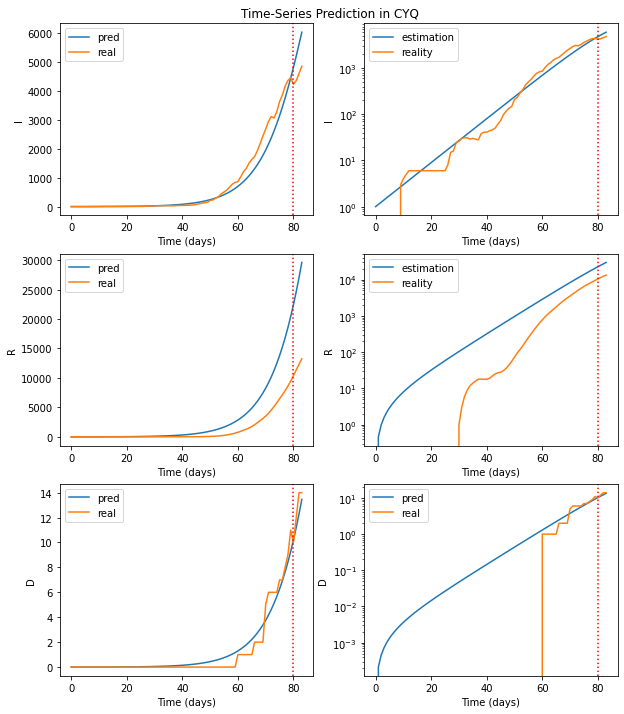

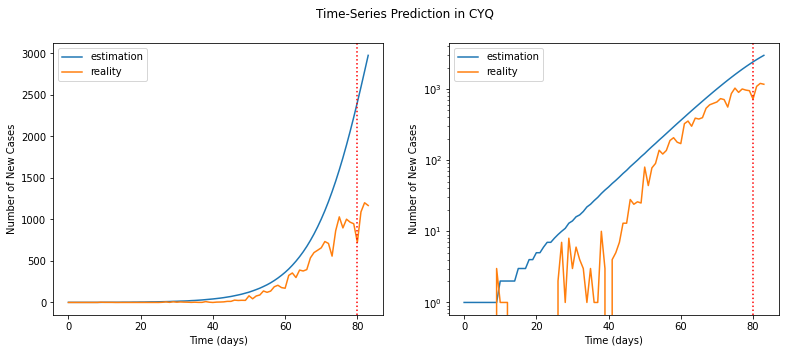

Diff: 141.53%
===== City: CYI =====
population = 263202
Best parameters: b = 0.55, g = 0.45000000000000007, u = 0.0002
Train minimal MSE = 136353.5820328653


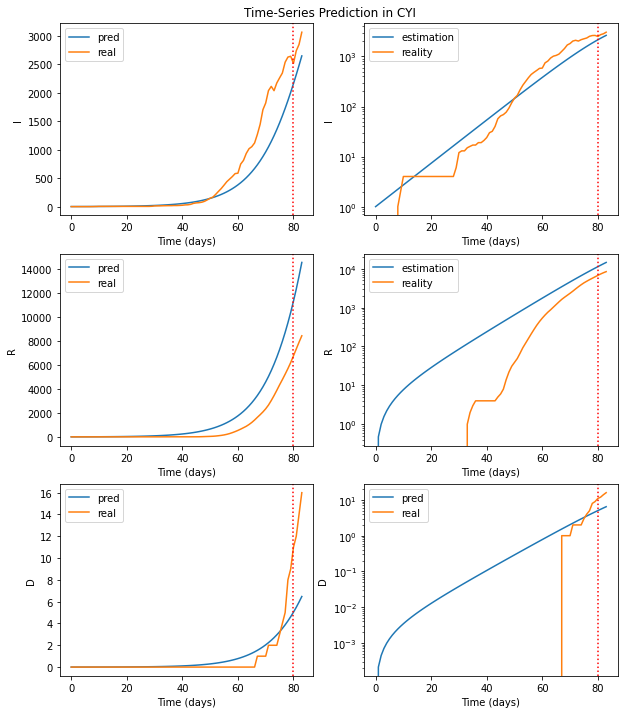

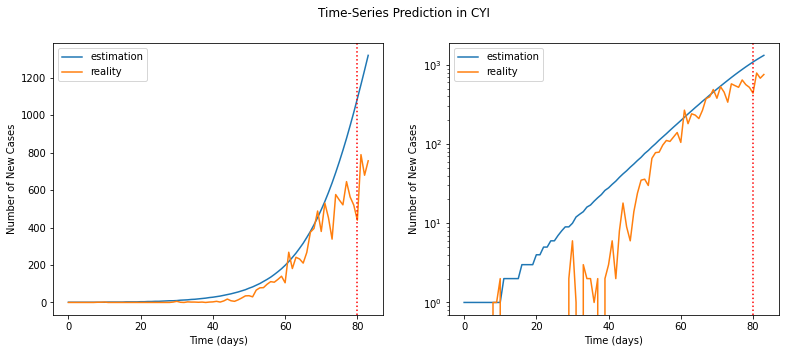

Diff: 67.36%
===== City: TNN =====
population = 1852429
Best parameters: b = 0.6400000000000001, g = 0.5000000000000001, u = 0.0002
Train minimal MSE = 11202147.058640875


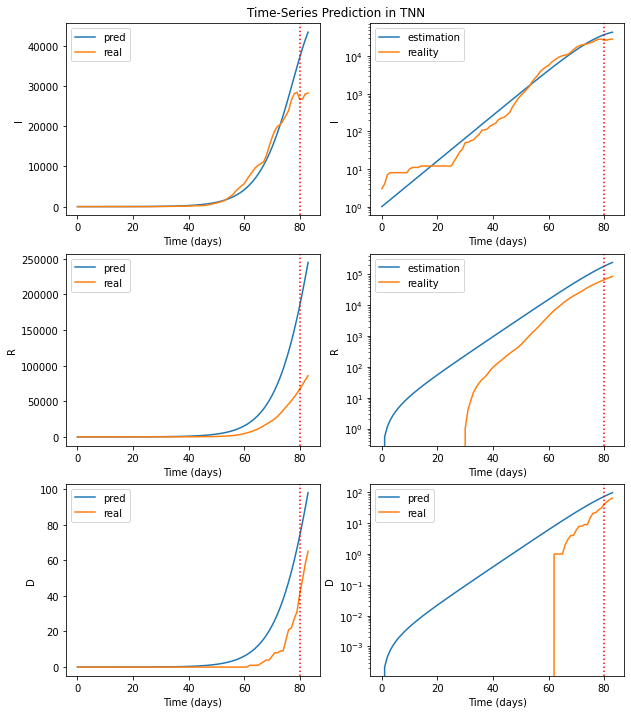

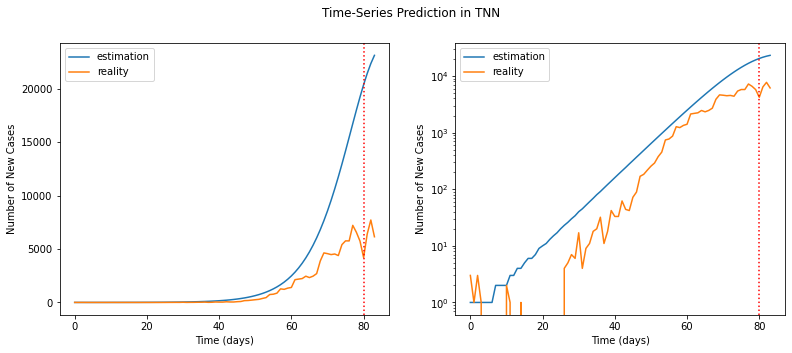

Diff: 230.12%
===== City: KHH =====
population = 2726087
Best parameters: b = 0.55, g = 0.41000000000000003, u = 0.0002
Train minimal MSE = 22630011.77138884


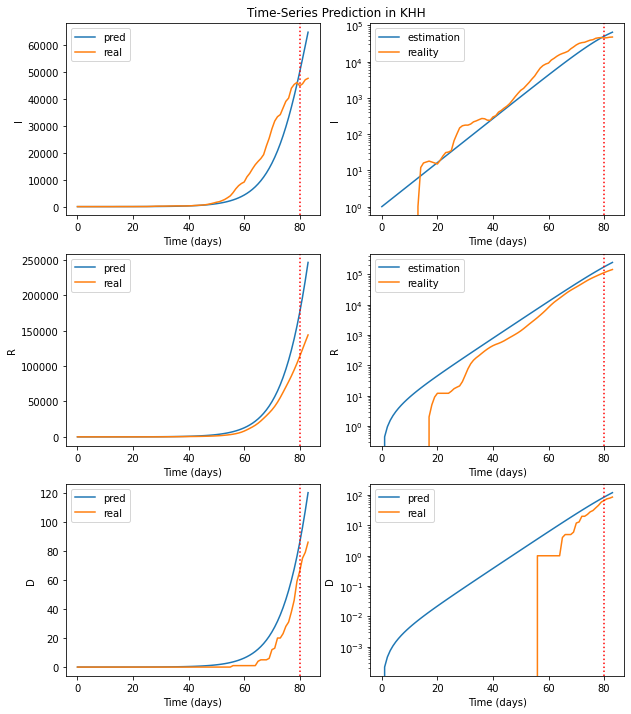

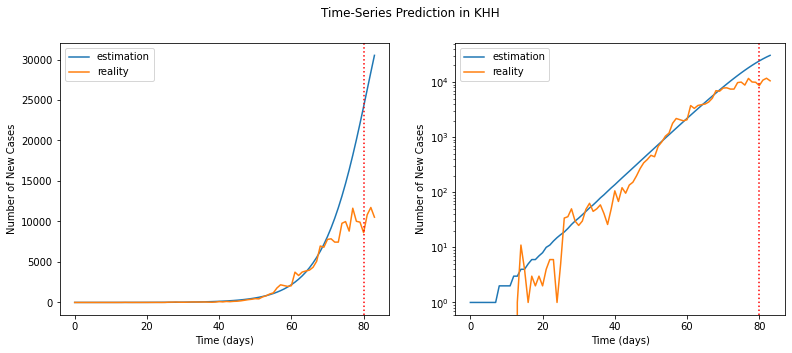

Diff: 157.57%
===== City: PIF =====
population = 801377
Best parameters: b = 0.6200000000000001, g = 0.4900000000000001, u = 0.0002
Train minimal MSE = 2527035.7813253435


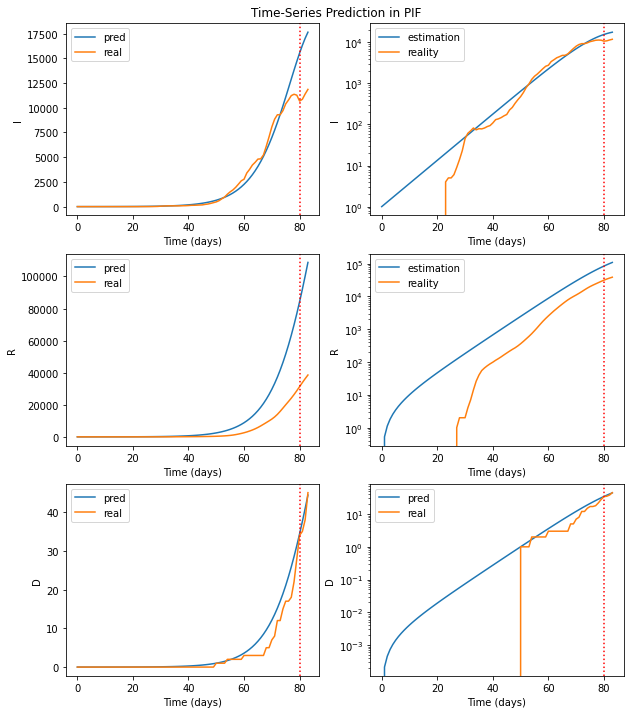

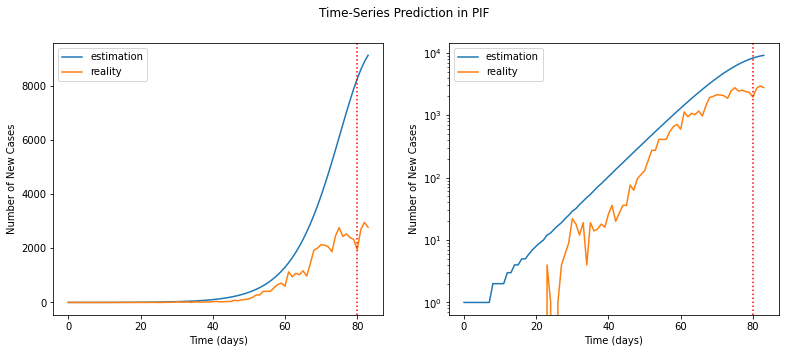

Diff: 215.82%
===== City: ILA =====
population = 448963
Best parameters: b = 0.6000000000000001, g = 0.4700000000000001, u = 0.0002
Train minimal MSE = 1988671.3459524908


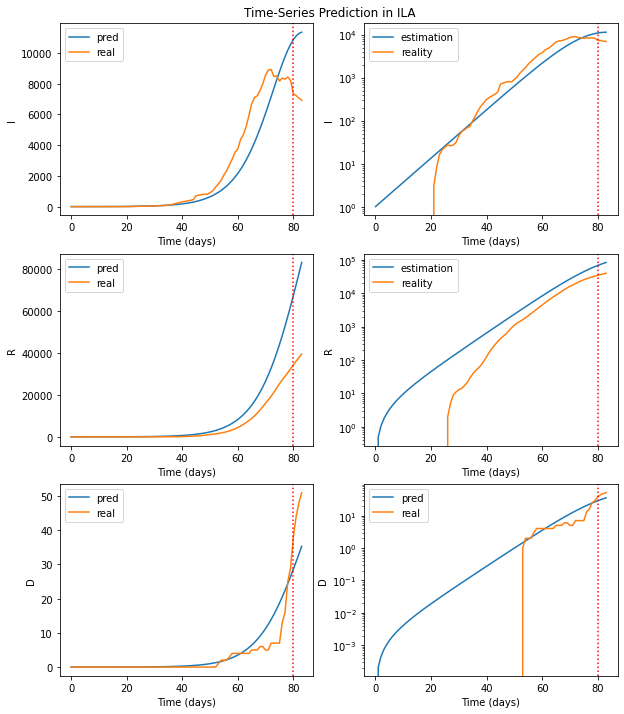

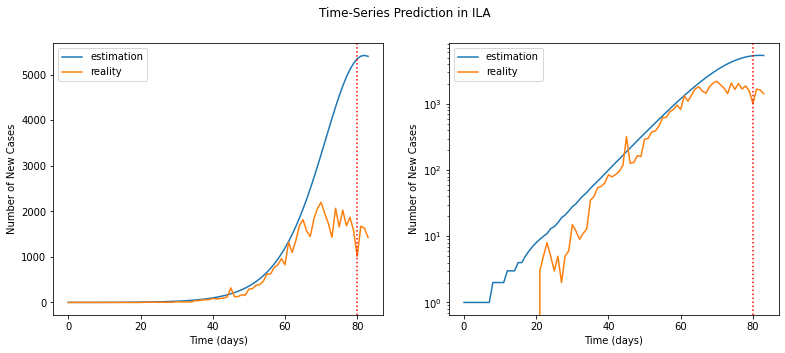

Diff: 243.24%
===== City: HUA =====
population = 319842
Best parameters: b = 0.55, g = 0.43000000000000005, u = 0.0002
Train minimal MSE = 1020006.9245366332


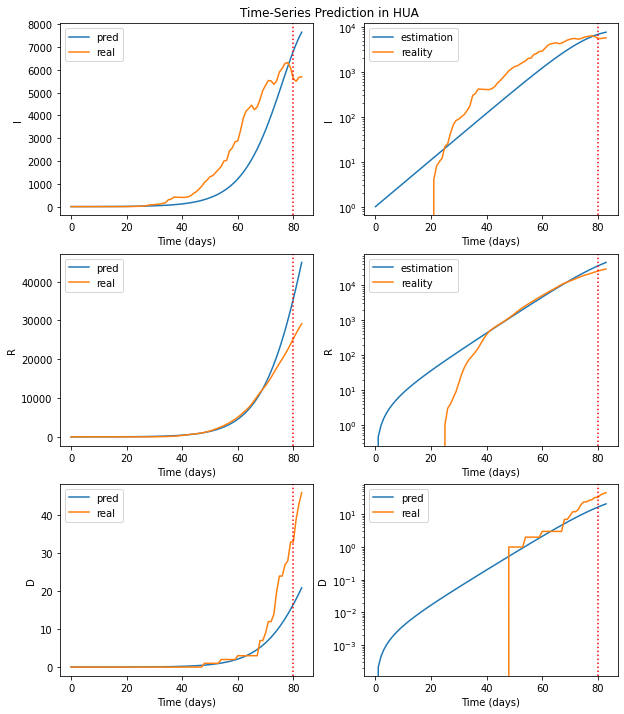

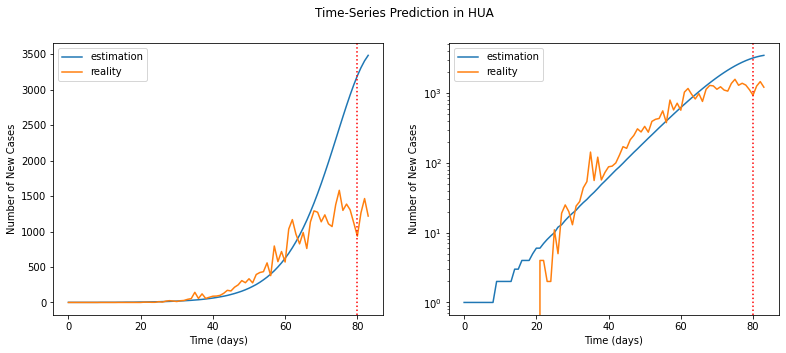

Diff: 158.45%
===== City: TTT =====
population = 212959
Best parameters: b = 0.55, g = 0.44000000000000006, u = 0.0002
Train minimal MSE = 127515.78412904553


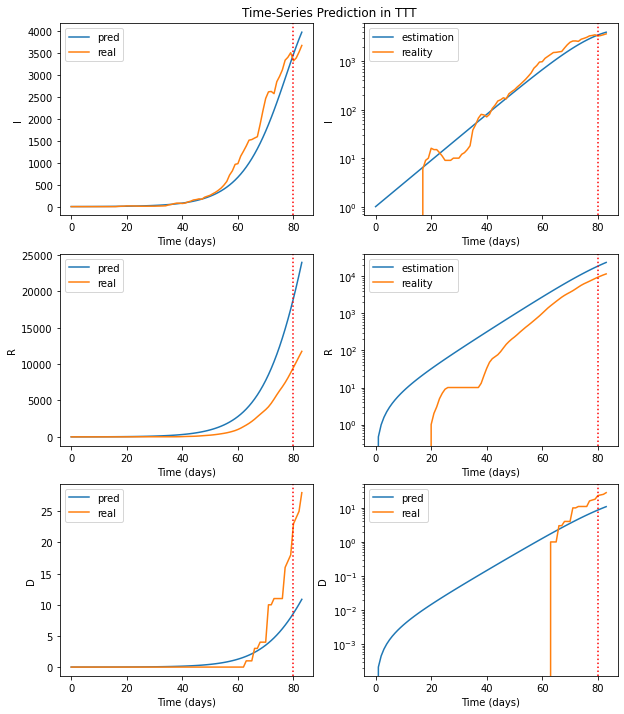

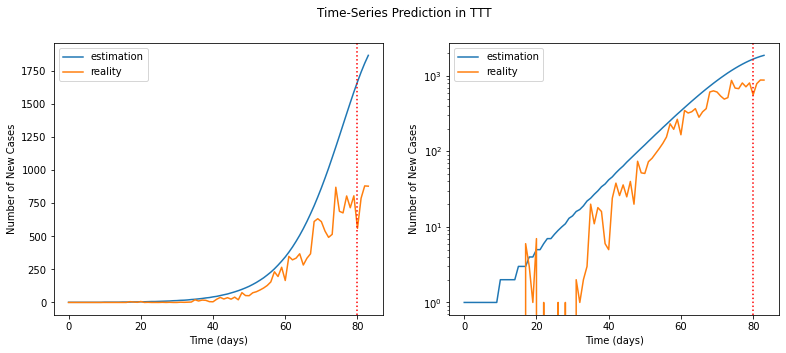

Diff: 112.60%
===== City: PEN =====
population = 106216
Best parameters: b = 0.55, g = 0.4600000000000001, u = 0.0002
Train minimal MSE = 15549.909651135342


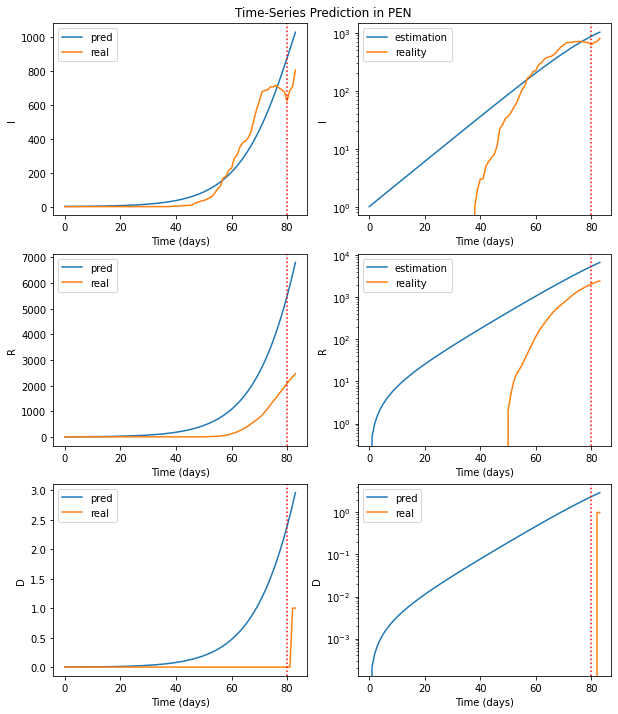

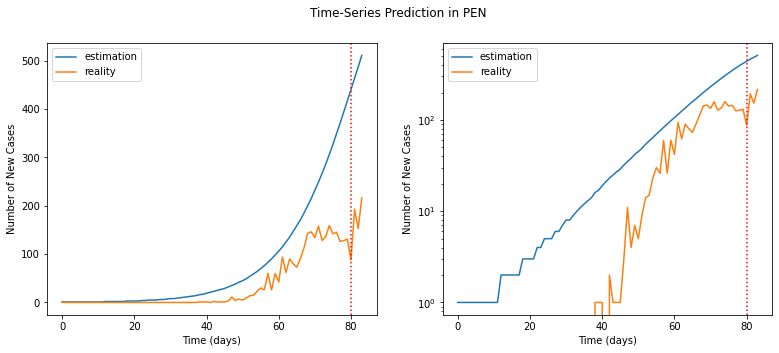

Diff: 160.14%
===== City: KIN =====
population = 140510
Best parameters: b = 0.55, g = 0.4700000000000001, u = 0.0002
Train minimal MSE = 14891.167062561044


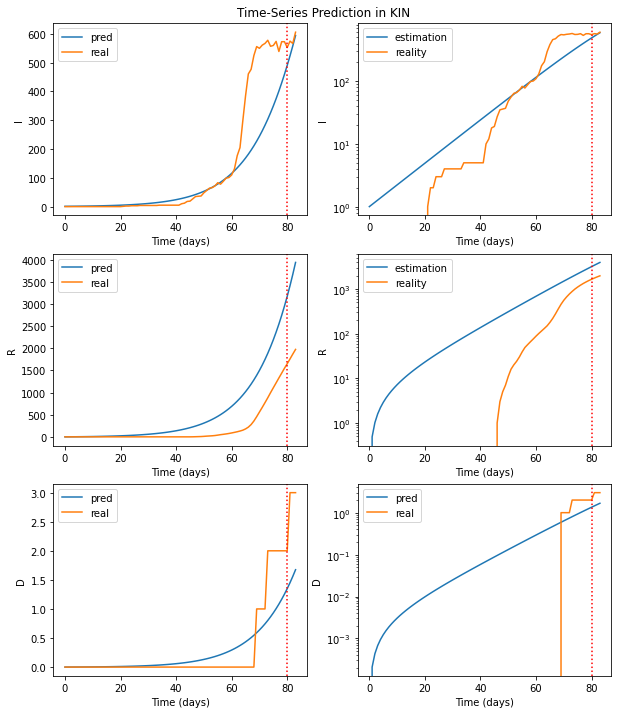

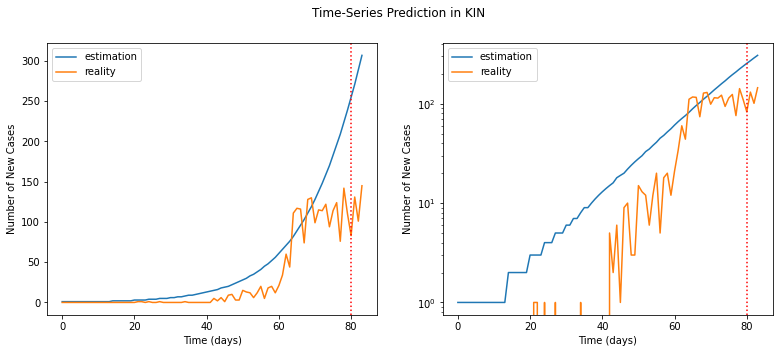

Diff: 129.97%
===== City: LIE =====
population = 13752
Best parameters: b = 0.55, g = 0.4800000000000001, u = 0.0002
Train minimal MSE = 2832.5617360058986


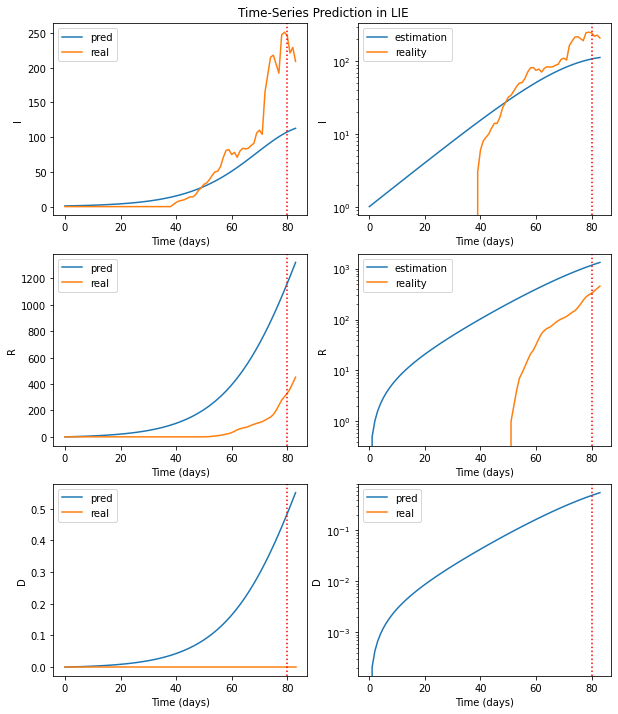

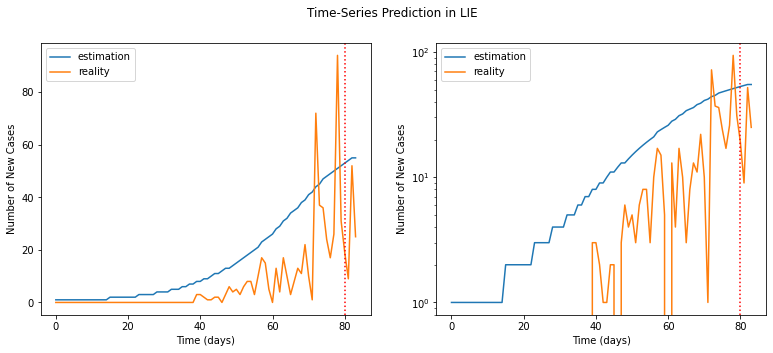

Diff: 90.70%


In [436]:
# TODO: read from file: diagnosed, population
populationDf = pd.read_csv('population.csv')
confirmedDf = pd.read_csv('timeline_diagnosed.csv')
deadDf = pd.read_csv('timeline_death.csv')

confirmedDf['date'] = pd.to_datetime(confirmedDf['date'], format='%Y-%m-%d')
confirmedDf.set_index('date', inplace=True)

deadDf['date'] = pd.to_datetime(deadDf['date'], format='%Y-%m-%d')
deadDf.set_index('date', inplace=True)

for city in city_code:
    # get new_infected_data for each city
    population, new_infected_data, timelineI, timelineR, timelineD = getCityData(populationDf, confirmedDf, deadDf, city)

    print(f"===== City: {city} =====")
    print(f"population = {population}")
    # print(f"I: {timelineI}")
    # print(f"R: {timelineR}")
    # print(f"D: {timelineD}")

    train_timelineI = timelineI[:train_size]
    train_timelineR = timelineR[:train_size]
    train_timelineD = timelineD[:train_size]
    b, g, u = estiCity(population, train_timelineI, train_timelineR, train_timelineD, city)
    plotEsti(timelineI, timelineR, timelineD, population, b, g, u, city)
    plotNewCases(new_infected_data, population, b, g, u, city)


## Source Reference
* https://colab.research.google.com/github/alsnhll/SEIR_COVID19/blob/master/SEIR_COVID19.ipynb